In [1]:
import uproot
import scipy
import numpy as np
import awkward as ak

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Purples'
plt.rcParams['figure.figsize'] = (9,7)
plt.rcParams['savefig.dpi'] = 200
plt.rc('figure', figsize=(9,7))
plt.rcParams['savefig.dpi']
plt.rcParams["lines.linewidth"] = 2

import mplhep as hep
plt.style.use(hep.style.ROOT)

from scipy.optimize import curve_fit
from scipy.stats import norm

In [12]:
f = uproot.open("/home/work/gem/testbeam/may2022/tracks/00000135_test.root")
f.keys()

['trackTree;23', 'trackTree;22']

In [13]:
t = f["trackTree"]
print(t.num_entries, "events")
t.show()

909248 events
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
orbitNumber          | int32_t                  | AsDtype('>i4')
bunchCounter         | int32_t                  | AsDtype('>i4')
eventCounter         | int32_t                  | AsDtype('>i4')
rechitDigiStrip      | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
rechitRawChannel     | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
rechitChamber        | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
rechitEta            | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitLocalX         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitLocalY         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitR              | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitPhi            | std::vector<double>      | AsJagged(AsD

In [21]:
keys = t.keys()
events = t.arrays(
    [
        "rechitClusterCenter", "rechitClusterSize", "rechitChamber", "rechitEta", "rechitLocalX",
        "prophitChamber", "prophitGlobalX", "prophitGlobalY"
    ],
    #entry_stop = 1000000
)
print(len(events["rechitClusterCenter"]), "events")

print(events["rechitChamber"])
print(events["rechitClusterCenter"])
print(events["rechitLocalX"])
print(events["rechitClusterSize"])

909248 events
[[0, 1, 2, 3, 4, 5, 8, 9, 10], [0, 1, 2, ... 4, 5, 8, 8, 9, 9, 10, 10], [8, 9, 10]]
[[345, 102, 348, 84, 347, 68, 312, 185, 176, ... 165, 171, 150], [280, 201, 194]]
[[41.6, -19.1, 42.4, -23.8, 42.1, -27.8, 159, ... -16.3, -36], [116, 7.56, 1.99]]
[[2, 2, 6, 7, 2, 1, 2, 1, 1], [3, 3, 4, 4, ... 3, 2, 1, 5, 2, 3, 3, 2, 2], [3, 2, 2]]


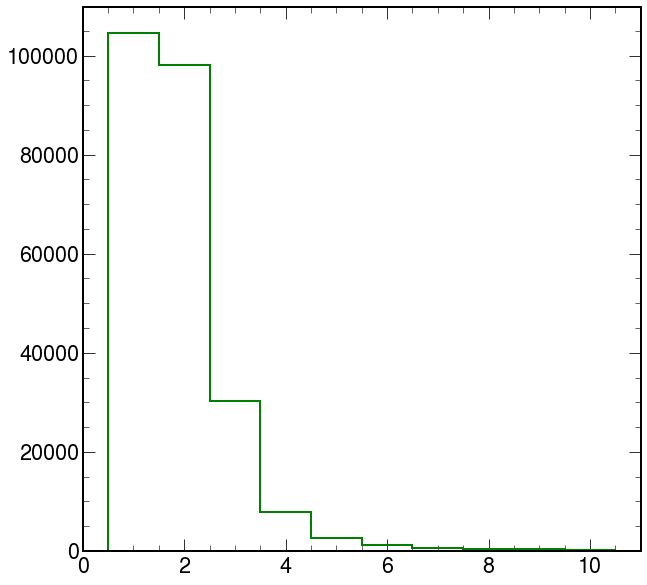

In [22]:
_ = plt.hist(
    ak.flatten(events["rechitClusterSize"][events["rechitChamber"]==chamber]),
    bins=10, linewidth=2, color="green", histtype="step", range=(0.5,10.5)
)
#_ = plt.hist(prophits_y, bins=100, linewidth=2, color="red", histtype="step")

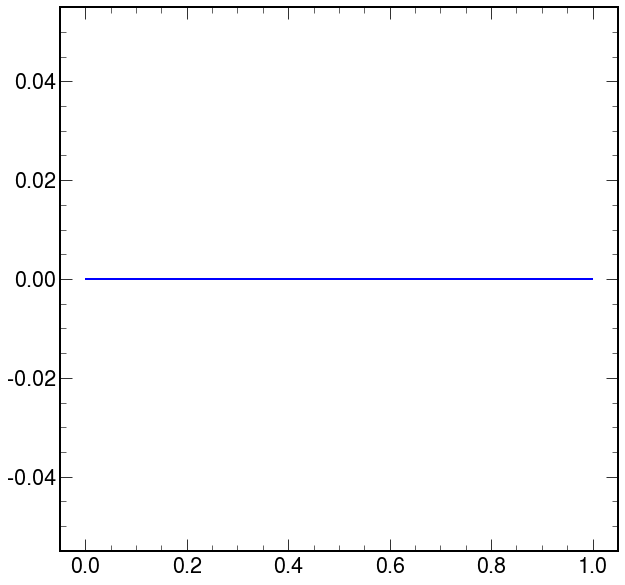

In [23]:
_ = plt.hist(
    ak.flatten(events["prophitGlobalX"][prophit_chamber==chamber]),
    bins=100, linewidth=2, color="green", histtype="step"
)
_ = plt.hist(
    ak.flatten(events["prophitGlobalY"][prophit_chamber==chamber]),
    bins=100, linewidth=2, color="blue", histtype="step"
)

In [20]:
chamber = 5
eta = 2

prophit_chamber = events["prophitChamber"]
prophits_x = ak.flatten(events["prophitGlobalX"][prophit_chamber==chamber])
prophits_y = ak.flatten(events["prophitGlobalY"][prophit_chamber==chamber])

rechit_chamber = events["rechitChamber"]
rechit_cluster_size = events["rechitClusterSize"]
rechit_eta = events["rechitEta"]

rechit_selection = (rechit_chamber==chamber)&(rechit_eta==eta)
rechit_selection = rechit_selection&(rechit_cluster_size==1)
strip_filter = (events["rechitClusterCenter"]>=0)&(events["rechitClusterCenter"]<=400)

print(events["rechitClusterSize"])
print(events["rechitClusterCenter"])
rechit_cluster_size = events["rechitClusterSize"][strip_filter][rechit_selection]
rechits_center = events["rechitClusterCenter"][strip_filter][rechit_selection]
#prophits_x = prophits_x[strip_filter]
print(rechits_center)

single_filter = ak.count(rechits_center, axis=1)>=0
print(ak.count(single_filter))
rechits_center = rechits_center[single_filter]
rechit_cluster_size = rechit_cluster_size[single_filter]
prophits_x = prophits_x[single_filter]
prophits_y = prophits_y[single_filter]

rechit_range = (ak.min(rechits_center)-0.5, ak.max(rechits_center)+0.5)
rechit_bins = int(rechit_range[1]-rechit_range[0])
print(rechit_range, rechit_bins)
_ = plt.hist(
    ak.flatten(rechits_center),
    bins=rechit_bins, range=rechit_range,
    linewidth=2, histtype="step"
)
print(rechits_center)

[[2, 2, 6, 7, 2, 1, 2, 1, 1], [3, 3, 4, 4, ... 3, 2, 1, 5, 2, 3, 3, 2, 2], [3, 2, 2]]
[[345, 102, 348, 84, 347, 68, 312, 185, 176, ... 165, 171, 150], [280, 201, 194]]
[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]
909248


ValueError: in NumpyArray attempting to get 0, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/cpu-kernels/awkward_regularize_arrayslice.cpp#L14)

In [ ]:
rechit_eta = events["rechitEta"][rechit_chamber==chamber]

plt.hist(ak.flatten(rechit_eta))

In [18]:
""" Quite useless because of the background, apart from debugging """

prophits_x_broad, _ = ak.broadcast_arrays(prophits_x, rechits_center)
_ = plt.scatter(
    ak.flatten(prophits_x_broad), ak.flatten(rechits_center),
)
prophits_y_broad, _ = ak.broadcast_arrays(prophits_y, rechits_center)
print(rechits_center, ak.count(ak.flatten(rechits_center)))
print(prophits_x_broad, ak.count(ak.flatten(prophits_x_broad)))

ValueError: cannot broadcast RegularArray of size 0 with RegularArray of size 909248

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/awkward/_util.py#L936)

[-10.4, 29.3, 23.6, 15.8, -0.715, 23.1, ... 21.7, 4.01, -14.4, 34.2, -17, 13.9]
[[], [299], [], [], [175], [272], [165], ... [], [], [121], [316, 318], [30], [237]]
[29.3, -0.715, 23.1, -4.25, -18.9, 3.26, ... 37.2, -14.4, 34.2, 34.2, -17, 13.9]
[17.5, 31.9, 39.5, -37.1, -2.47, 3.14, ... 6.48, 15.7, -25.4, -25.4, 36.1, -9.7]
[299, 175, 272, 165, 184, 169, 164, 289, ... 275, 268, 330, 121, 316, 318, 30, 237]
1808655 1808655 1808655
lengths (50, 50) (50,) (50,)
center
[-39.2 -37.6 -36.  -34.4 -32.8 -31.2 -29.6 -28.  -26.4 -24.8 -23.2 -21.6
 -20.  -18.4 -16.8 -15.2 -13.6 -12.  -10.4  -8.8  -7.2  -5.6  -4.   -2.4
  -0.8   0.8   2.4   4.    5.6   7.2   8.8  10.4  12.   13.6  15.2  16.8
  18.4  20.   21.6  23.2  24.8  26.4  28.   29.6  31.2  32.8  34.4  36.
  37.6  39.2]
[-39.2 -37.6 -36.  -34.4 -32.8 -31.2 -29.6 -28.  -26.4 -24.8 -23.2 -21.6
 -20.  -18.4 -16.8 -15.2 -13.6 -12.  -10.4  -8.8  -7.2  -5.6  -4.   -2.4
  -0.8   0.8   2.4   4.    5.6   7.2   8.8  10.4  12.   13.6  15.2  16.8
  18.

Text(0, 1, 'Rechit strip')

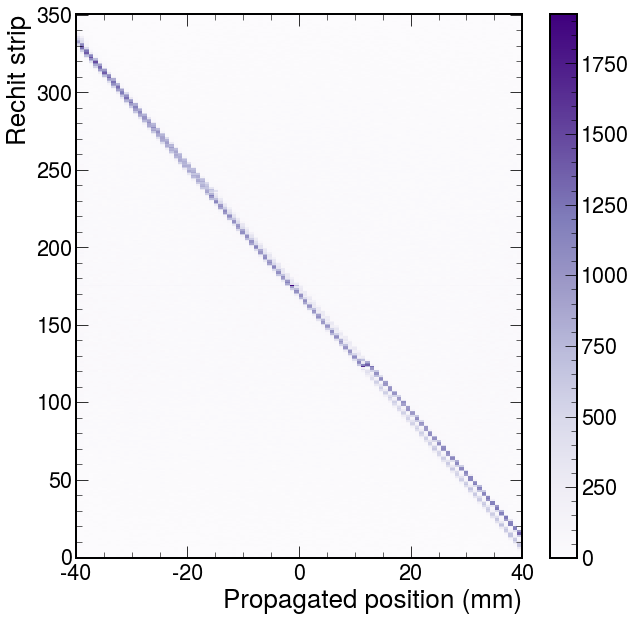

In [222]:
""" Perform calibration of propagated x to strip on detector """
print(prophits_x)
print(rechits_center)
prophits_x_broad, _ = ak.broadcast_arrays(prophits_x, rechits_center)
prophits_y_broad, _ = ak.broadcast_arrays(prophits_y, rechits_center)

prophit_range = (-40,40)
strip_range = (0-0.5, 350+0.5)
strip_bins = int(strip_range[1]-strip_range[0]-1)

_ = plt.hist2d(
    ak.flatten(prophits_y_broad), ak.flatten(rechits_center),
    bins=(100, strip_bins), range=(prophit_range,strip_range),
    #norm=mpl.colors.LogNorm()
)
plt.colorbar()

print(ak.flatten(prophits_x_broad), ak.flatten(prophits_y_broad), ak.flatten(rechits_center), sep="\n")
print(ak.num(prophits_x_broad, axis=0), ak.num(prophits_y_broad, axis=0), ak.num(rechits_center, axis=0), sep=" ")
""" Bin the propagated hits """
strip_means, prophit_x_edges, prophit_y_edges, _ = scipy.stats.binned_statistic_2d(
    ak.flatten(prophits_x_broad), ak.flatten(prophits_y_broad), ak.flatten(rechits_center),
    lambda x: scipy.stats.mode(x)[0][0], bins=50, range=(prophit_range,prophit_range),
    #lambda x: scipy.stats.mode(x), bins=50, range=prophit_range
)

prophit_x_centers = 0.5*(prophit_x_edges[1:]+prophit_x_edges[:-1])
prophit_x_errs = 0.5*(prophit_x_edges[1:]-prophit_x_edges[:-1])
prophit_y_centers = 0.5*(prophit_y_edges[1:]+prophit_y_edges[:-1])
prophit_y_errs = 0.5*(prophit_y_edges[1:]-prophit_y_edges[:-1])

print("lengths", strip_means.shape, prophit_x_centers.shape, prophit_y_centers.shape)
print("center", prophit_x_centers, prophit_y_centers, sep="\n")
print("means", strip_means)

prophit_y_centers, prophit_x_centers = np.meshgrid(prophit_x_centers, prophit_y_centers)
print("lengths", strip_means.shape, prophit_x_centers.shape, prophit_y_centers.shape)
"""_ = plt.errorbar(
    prophit_x_centers, strip_means, xerr=prophit_x_errs, fmt="ok"
)"""

def linear (X, A, B, C):
    x, y = X
    return A*x + B*y + C

p0 = [1, 10, 10]
print("test", linear((prophit_x_centers, prophit_y_centers), *p0))
"""popt, pcov = curve_fit(
    linear,
    (ak.flatten(prophits_x_broad), ak.flatten(prophits_x_broad)),
    ak.flatten(rechits_center), p0=p0
)"""
popt, pcov = curve_fit(linear, (prophit_x_centers.flatten(), prophit_y_centers.flatten()), strip_means.flatten(), p0=p0)
print(popt)
prophits_center = linear((prophits_x, prophits_y), *popt)

"""x = np.linspace(prophit_range[0], prophit_range[1], 100)
_ = plt.plot(
    x, linear(x, *popt), "-", color="red"
)"""
plt.xlabel("Propagated position (mm)")
plt.ylabel("Rechit strip")

Text(0, 1, 'Propagated strip')

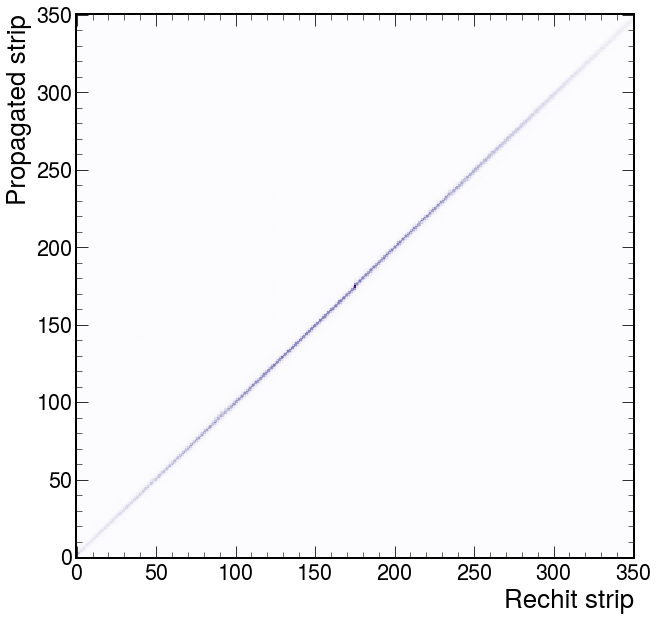

In [223]:
""" Check that the calibration went well """

prophits_center_broad, _ = ak.broadcast_arrays(prophits_center, rechits_center)

_ = plt.hist2d(
    ak.flatten(rechits_center), ak.flatten(prophits_center_broad),
    bins=(strip_bins, strip_bins), range=(strip_range, strip_range)
)
plt.xlabel("Rechit strip")
plt.ylabel("Propagated strip")

residuals [[], [3.63], [], [], [-0.216], [1.84], ... [], [], [0.206], [], [-80.2], [2.56]]
[3.63, -0.216, 1.84, 2.56, 80.6, -22.6, ... 0.121, 187, -58.8, 0.206, -80.2, 2.56]
RMS 1.6704504178946014
[9.74547203e+04 4.28434883e-01 1.84299893e+00 2.83500551e+04
 6.92565031e-02 6.80277362e-01]
[1.13574131e+03 1.33746613e-02 2.00591178e-02 1.21914276e+03
 8.42858923e-03 1.44120307e-02]
sigma1 = 1.84 +- 0.02
mean = 0.43


Text(1, 0, 'Residual strip')

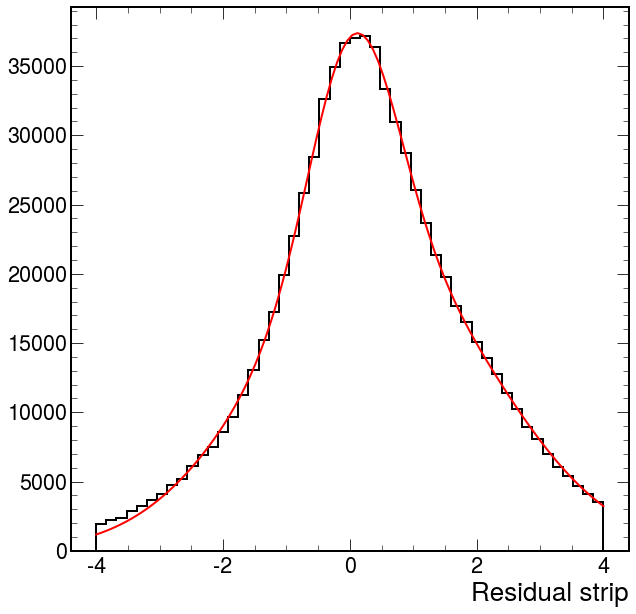

In [224]:
residuals = rechits_center - prophits_center_broad

residual_filter = (rechits_center>0)&(rechits_center<300)
#residual_filter = (rechits_center>0)&(rechits_center<400)
#residual_filter = (residual_filter)&(rechit_cluster_size==cluster_size)
residuals = residuals[residual_filter]
print("residuals", residuals)

gauss = lambda x, A, mean, sigma: A*norm.pdf(x, mean, sigma)
gauss2 = lambda x, A1, mean1, sigma1, A2, mean2, sigma2: gauss(x, A1, mean1, sigma1) + gauss(x, A2, mean2, sigma2)

residuals_flat = ak.flatten(residuals)
residuals_min_filter = ak.argmin(abs(residuals), axis=1, keepdims=True)
residuals_flat = ak.flatten(residuals[residuals_min_filter])
residuals_flat = residuals_flat[~ak.is_none(residuals_flat)]
print(residuals_flat)
residual_values, residual_edges, _ = plt.hist(
    residuals_flat,
    bins=50, range=(-4, 4),
    color="black", histtype="step", linewidth=2
)
residual_bins = 0.5*(residual_edges[1:]+residual_edges[:-1])
print("RMS", ak.std(residuals_flat[abs(residuals_flat)<5]))

p0 = [10, 0, 0.5] + [0.1, 0, 5]
popt, pcov = curve_fit(gauss2, residual_bins, residual_values, p0=p0)
perr = np.sqrt(np.diag(pcov))
#popt, pcov = curve_fit(gauss, residual_bins, residual_values, p0=p0)
print(popt)
print(perr)
A, mean, sigma = popt[:3]
print(f"sigma1 = {popt[2]:1.2f} +- {perr[2]:1.2f}")
#print(f"sigma2 = {popt[5]:1.2f}")
print(f"mean = {popt[1]:1.2f}")


x = np.linspace(residual_edges[0], residual_edges[-1], 100)
y = gauss2(x, *popt)
plt.plot(x, y, "-", color="red")
plt.xlabel("Residual strip")

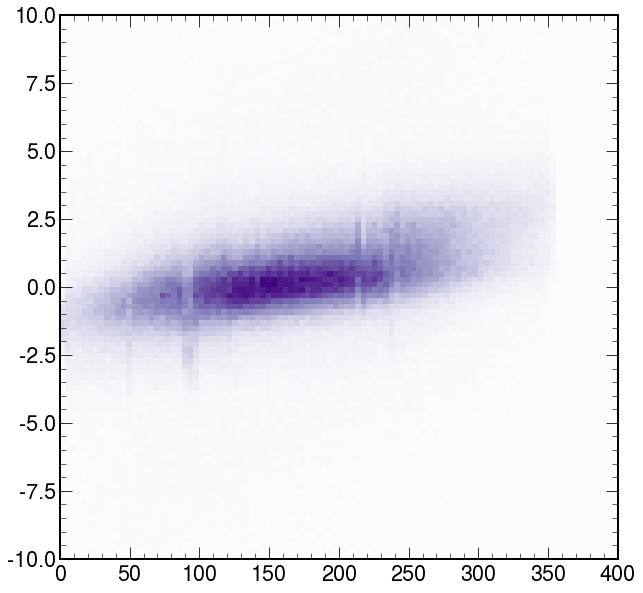

In [225]:
residuals = rechits_center - prophits_center_broad

_ = plt.hist2d(
    ak.flatten(prophits_center_broad),
    ak.flatten(residuals),
    bins=100, range=((0,400),(-10,10))
)

[3.63, 1.84, 2.7, 1.52, 1.26, 192, -24.8, ... 0.621, 1.47, 0.121, 187, -58.8, 2.56]
RMS 1.5919402841138597
[3.00594416e+03 3.64264679e-01 5.35538637e-01 1.74617489e+04
 1.25726775e+00 1.55912938e+00]
[1.71891149e+02 1.41569557e-02 1.87116589e-02 1.89285983e+02
 1.89929831e-02 1.36185168e-02]
sigma1 = 0.54 +- 0.02
mean = 0.36
[]
RMS nan
[-1.10941495e-17  6.18653041e-12  9.99999995e-01 -3.47310077e-17
 -1.72736606e-08  1.00000012e+01]
[inf inf inf inf inf inf]
sigma1 = 1.00 +- inf
mean = 0.00
[]
RMS nan
[-1.10941495e-17  6.18653041e-12  9.99999995e-01 -3.47310077e-17
 -1.72736606e-08  1.00000012e+01]
[inf inf inf inf inf inf]
sigma1 = 1.00 +- inf
mean = 0.00


/home/antonellopellecchia/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/antonellopellecchia/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[]
RMS nan
[-1.10941495e-17  6.18653041e-12  9.99999995e-01 -3.47310077e-17
 -1.72736606e-08  1.00000012e+01]
[inf inf inf inf inf inf]
sigma1 = 1.00 +- inf
mean = 0.00
[]
RMS nan
[-1.10941495e-17  6.18653041e-12  9.99999995e-01 -3.47310077e-17
 -1.72736606e-08  1.00000012e+01]
[inf inf inf inf inf inf]
sigma1 = 1.00 +- inf
mean = 0.00


/home/antonellopellecchia/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/antonellopellecchia/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


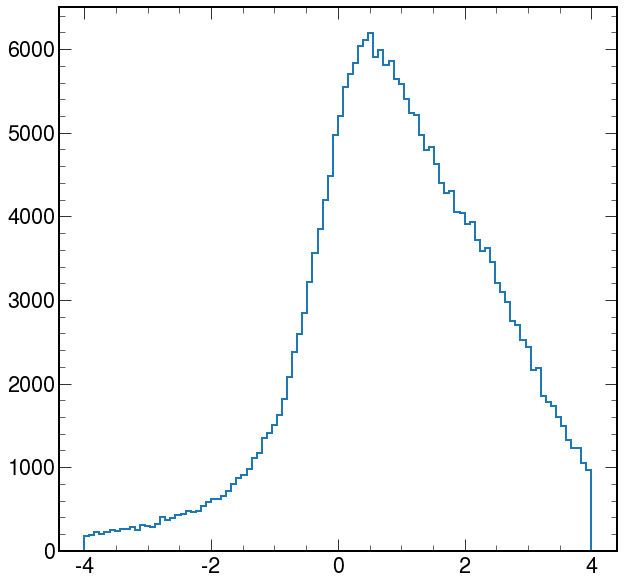

In [226]:
sigma_cls = dict()
sigma_cls_err = dict()

for cluster_size in range(1, 6):
    residuals = rechits_center - prophits_center_broad
    residual_filter = (rechits_center>200)&(rechits_center<300)
    residual_filter = (residual_filter)&(rechit_cluster_size==cluster_size)
    residuals = residuals[residual_filter]

    gauss = lambda x, A, mean, sigma: A*norm.pdf(x, mean, sigma)
    gauss2 = lambda x, A1, mean1, sigma1, A2, mean2, sigma2: gauss(x, A1, mean1, sigma1) + gauss(x, A2, mean2, sigma2)

    residuals_flat = ak.flatten(residuals)
    residuals_min_filter = ak.argmin(abs(residuals), axis=1, keepdims=True)
    residuals_flat = ak.flatten(residuals[residuals_min_filter])
    residuals_flat = residuals_flat[~ak.is_none(residuals_flat)]
    print(residuals_flat)
    _ = residual_values, residual_edges, _ = plt.hist(
        residuals_flat,
        bins=100, range=(-4, 4),
        histtype="step", linewidth=2
    )
    residual_bins = 0.5*(residual_edges[1:]+residual_edges[:-1])
    print("RMS", ak.std(residuals_flat[abs(residuals_flat)<5]))

    p0 = [1, 0, 1] + [0.1, 0, 10]
    popt, pcov = curve_fit(gauss2, residual_bins, residual_values, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    #popt, pcov = curve_fit(gauss, residual_bins, residual_values, p0=p0)
    print(popt)
    print(perr)
    #A, mean, sigma = popt
    print(f"sigma1 = {popt[2]:1.2f} +- {perr[2]:1.2f}")
    #print(f"sigma2 = {popt[5]:1.2f}")
    print(f"mean = {popt[1]:1.2f}")
    
    sigma_cls[cluster_size] = popt[2]
    sigma_cls_err[cluster_size] = perr[2]

    x = np.linspace(residual_edges[0], residual_edges[-1], 100)
    y = gauss2(x, *popt)
    #plt.plot(x, y, "-", color="red")
    #plt.xlabel("Residual strip")

Text(0, 1, 'Sigma of residuals (strips)')

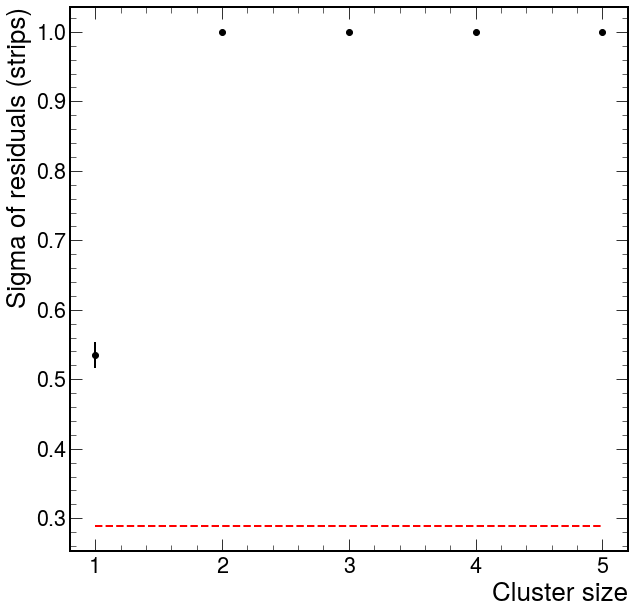

In [227]:
plt.errorbar(
    sigma_cls.keys(), sigma_cls.values(),
    yerr = sigma_cls_err.values(), fmt="ok"
)
plt.plot(
    sigma_cls.keys(), [12**(-0.5)]*len(sigma_cls), "--", color="red"
)
plt.xlabel("Cluster size")
plt.ylabel("Sigma of residuals (strips)")

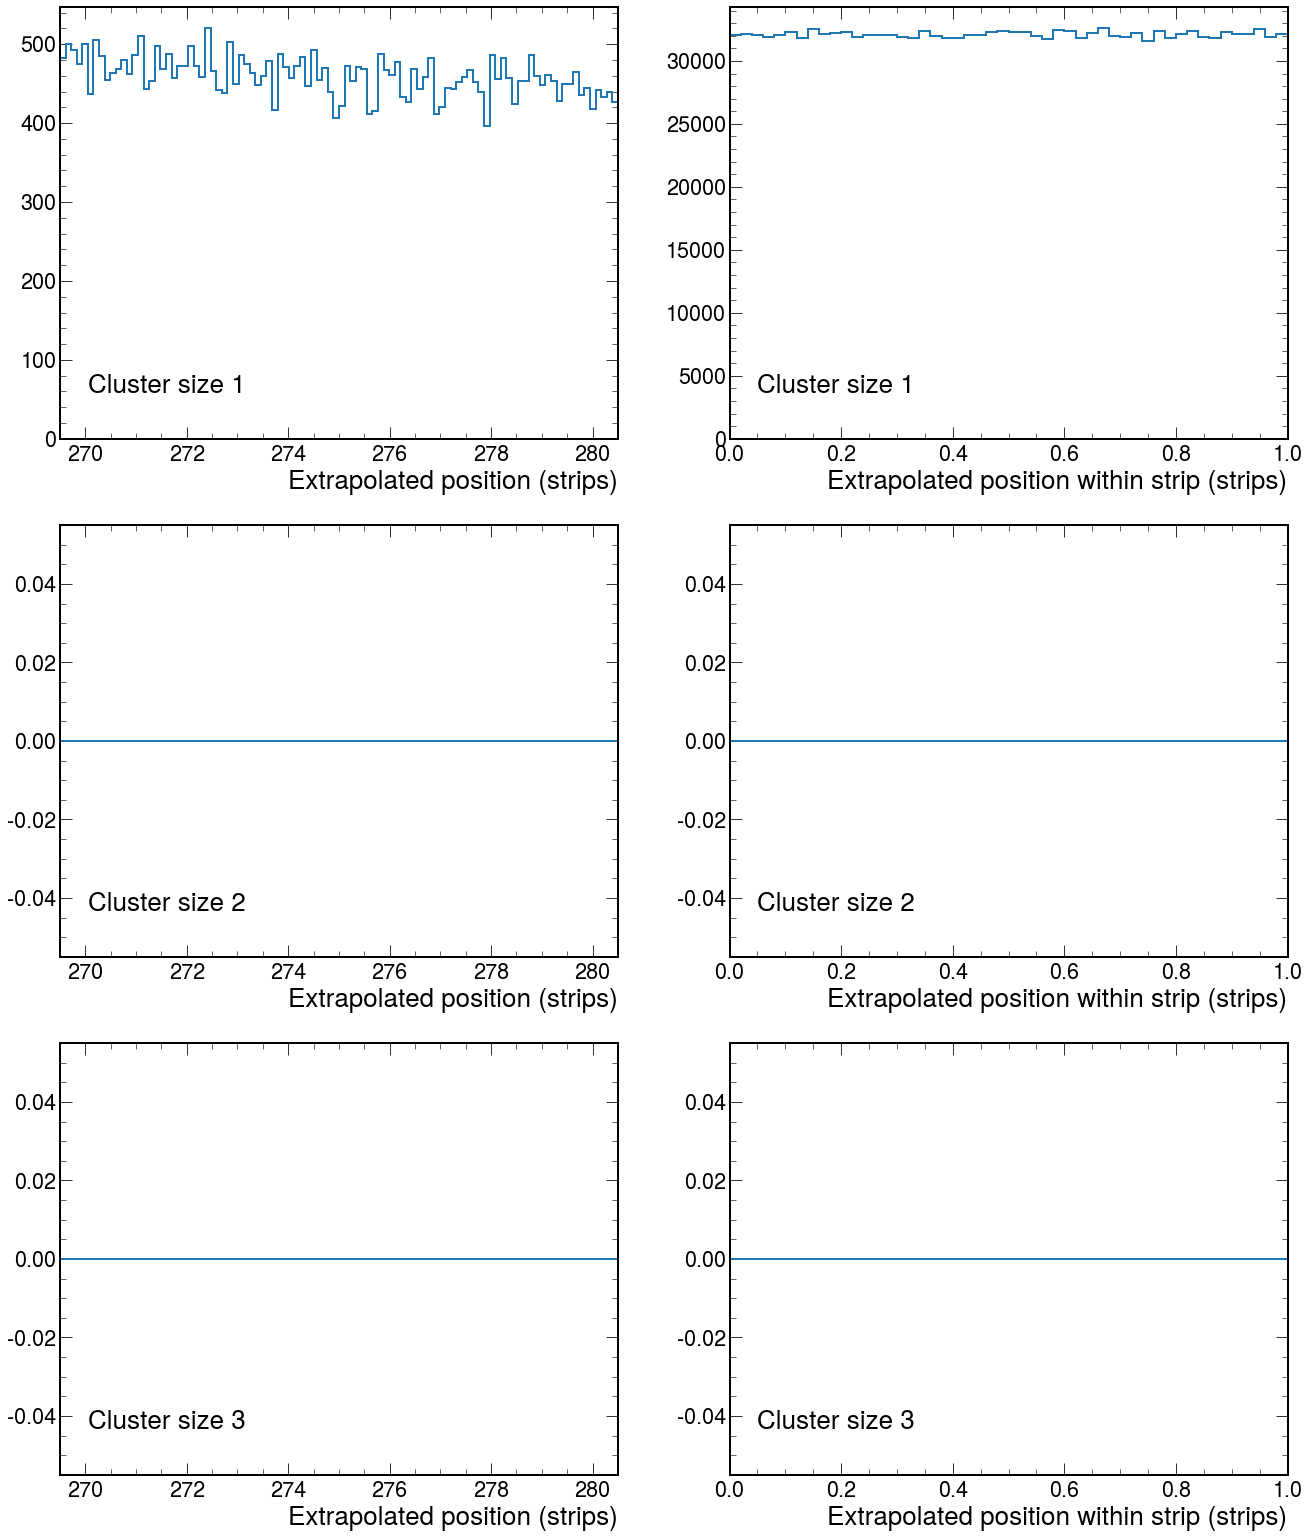

In [228]:
n_cluster_sizes = 3
fig, axs = plt.subplots(ncols=2, nrows=n_cluster_sizes, figsize=(22,9*n_cluster_sizes))

#prophits_center_aligned = prophits_center_broad - mean
horn_resolution = 10 # fraction of strips to plot
horn_range= (270-0.5, 280+0.5)
horn_bins = 10*horn_resolution

for i,cluster_size in enumerate(range(1, n_cluster_sizes+1)):
    
    prophits_cls = prophits_center_broad[rechit_cluster_size==cluster_size]
    
    residual_cls = rechits_center - prophits_center_broad
    residual_mean = ak.mean(ak.flatten(residual_cls))
    
    prophits_cls = prophits_cls[~ak.is_none(prophits_cls)]
    prophits_cls = prophits_cls - residual_mean
    _ = axs[i][0].hist(
        ak.flatten(prophits_cls), density=False,
        bins=horn_bins, range=horn_range,
        linewidth=2, histtype="step",
        label=f"Cluster size: {cluster_size}"
    )
    axs[i][0].text(
        0.05, 0.15,
        f"Cluster size {cluster_size}",
        transform = axs[i][0].transAxes,
        va="top", ha="left"
    )
    axs[i][0].set_xlim(horn_range[0], horn_range[1])
    axs[i][0].set_xlabel("Extrapolated position (strips)")

    prophits_within_strip = ak.flatten(prophits_cls).to_numpy() + 0.5
    #prophits_within_strip -= prophits_within_strip.max()
    prophits_within_strip -= np.floor(prophits_within_strip)
    _ = axs[i][1].hist(
        prophits_within_strip, density=False,
        bins=50, #range=(0,1),
        linewidth=2, histtype="step",
        label=f"Cluster size {cluster_size}"
    )
    axs[i][1].set_xlim(0,1)
    axs[i][1].text(
        0.05, 0.15,
        f"Cluster size {cluster_size}",
        transform = axs[i][1].transAxes,
        va="top", ha="left"
    )
    axs[i][1].set_xlabel("Extrapolated position within strip (strips)")

#axs[i].legend()